# Layer Combination and Favorability Modeling `geoPFA`: 3D Example from Newberry Volcano, OR
This notebook continues the `geoPFA` tutorial series using the **processed data** prepared in the previous notebook.  
Here, we load the preprocessed configuration and datasets, then use the *Voter–Veto* method to combine layers into geothermal favorability models.  

We’ll cover:
- Loading the processed PFA configuration  
- Reestablishing project paths, reference CRS, data extent, etc.
- Reading in supporting data for plotting and visualization


## 1. Imports and Setup

In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd

# geoPFA modules
from geoPFA.data_readers import GeospatialDataReaders
from geoPFA.processing import Cleaners
from geoPFA.geopfa3d.layer_combination import VoterVeto
from geoPFA.geopfa3d.plotters import GeospatialDataPlotters
from geoPFA.io import GeospatialDataWriters

# Utility
from rex.utilities.utilities import safe_json_load

### Define Directories and CRS


In [2]:
# Target CRS (UTM Zone 10N for Newberry, Oregon)
target_crs = 26910

# Define key directories relative to this notebook
notebook_dir = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd()
project_dir = notebook_dir.parent

data_dir = project_dir / "data"
config_dir = project_dir / "config"

print("Notebook directory:", notebook_dir)
print("Data directory:", data_dir)
print("Config directory:", config_dir)


Notebook directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/notebooks
Data directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/data
Config directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/config


### Load the Processed PFA Configuration
TODO: Get rid of velocity layers in last nb and rename this. If we can get extrapolation working, add velocity to this nb.

In [3]:
pfa_path = config_dir / "newberry_superhot_processed_config.json"
pfa = safe_json_load(str(pfa_path))  # Convert Path → str for safe_json_load
print(f"Loaded PFA configuration from: {pfa_path.name}")

Loaded PFA configuration from: newberry_superhot_processed_config.json


### Load Project Boundary for Plotting

In [4]:
outline_path = data_dir / "supporting_data" / "national_monument_boundary" / "NNVM_bounds.shp"
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded project outline: {outline_path.name}")

Loaded project outline: NNVM_bounds.shp


## 2. Reading Processed Data and Setting Extent

Now that we’ve loaded the processed configuration, we’ll read the **processed data layers** that were generated in the previous notebook.  
Each dataset corresponds to the `model` output created by functions such as `interpolate_points_3d`, `point_density_3d_projected`, or `distance_from_3d_solids`.

This step ensures that every layer is loaded with consistent metadata (CRS, extent, units) before being combined.

### Read Processed Data

In [5]:
pfa = GeospatialDataReaders.gather_processed_data(data_dir,pfa,crs=target_crs)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: earthquakes
	 component: producibility
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: faults_3d
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: temperature_model_500m


Each layer is placed back under
pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]
exactly where the processing functions would have written it in the previous step.

#### Set Extent
To ensure proper alignment, we’ll re-establish the same 3D extent used during processing.
This guarantees that layer combination occurs on a consistent grid.

In [6]:
extent_layer = (
    pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["model"]
)
extent = Cleaners.get_extent_3d(extent_layer)
extent[2] = np.float64(-6000)  # manually enforce lower z limit for Newberry

print(f"Extent: {extent}")

Extent: [np.float64(624790.875), np.float64(4825350.5), np.float64(-6000.0), np.float64(653145.875), np.float64(4855310.5), np.float64(2379.88427734375)]


The extent should match exactly what was defined in the previous notebook.
If layers were processed elsewhere or on a different grid, they must be re-projected or re-interpolated before combination.

## 3. Transformation and Layer Combination

With all data aligned, we can now combine layers into **component** and **criteria** favorability models using the *Voter–Veto* method.

The method:
- Weights and normalizes each layer
- Combines layers to form component favorabiltiy (e.g., heat, producibility, insulation)
- Combines components into a higher-level criteria models (e.g., geologic favorability)
- Optionally normalizes outputs to a defined scale (e.g., 0–5)

In [7]:
# Combine layers into favorability models
pfa = VoterVeto.do_voter_veto(
    pfa,
    normalize_method="minmax",  # normalize each layer between its min & max
    component_veto=False,       # no veto at the component level
    criteria_veto=True,         # apply veto across components if needed
    normalize=True,             # normalize final favorability model
    norm_to=5,                  # scale favorability to 0-5
)

print("Layer combination complete using the Voter-Veto method.")


density_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
mt_resistivity_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
temperature_model_500m
Transformed a layer using None
Normalized a layer using minmax
earthquakes
Transformed a layer using negate
Normalized a layer using minmax
density_joint_inv
Normalized a layer using minmax
mt_resistivity_joint_inv
Normalized a layer using minmax
earthquakes
Normalized a layer using minmax
faults_3d
Transformed a layer using negate
Normalized a layer using minmax
density_joint_inv
Normalized a layer using minmax
mt_resistivity_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
earthquakes
Transformed a layer using negate
Normalized a layer using minmax
temperature_model_500m
Transformed a layer using negate
Normalized a layer using minmax
Layer combination complete using the Voter-Veto method.


## 4. Visualizing Favorability Results

With the *Voter–Veto* layer combination complete, we can now visualize the resulting
favorability models in 3D.

Each output is stored under:
- `pfa["criteria"][criteria]["components"][component]["pr_norm"]` - normalized **component** favorability  
- `pfa["criteria"][criteria]["pr_norm"]` - normalized **criteria**-level (overall) favorability  

We’ll plot only the individual component models here. We do not recommend using this model for 3D interpretation due to a lack of visibility into components, given that each component exists in a distinct location in 3D space, stacked over one another. This means that the highest combined geologic favorability may indicate mild favorability for all components in an overlapping location, which is ultimately unfavorable for geothermal development.


### Component Favorability Models - Filtered

Plot individual component favorability layers.

geologic
	heat


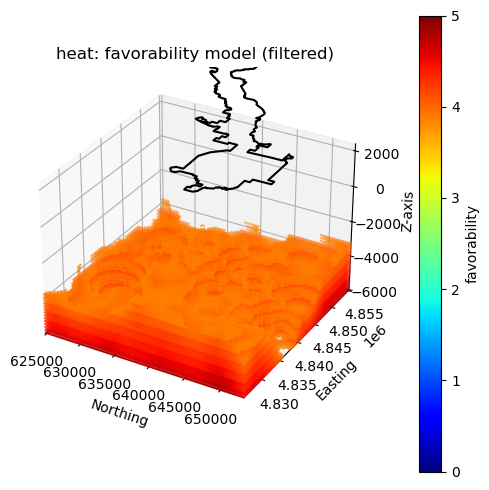

	producibility


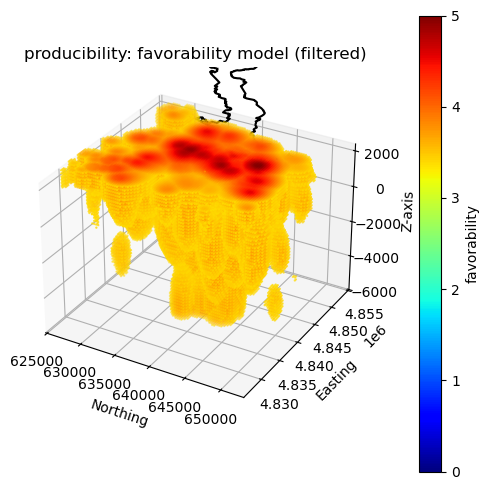

	insulation


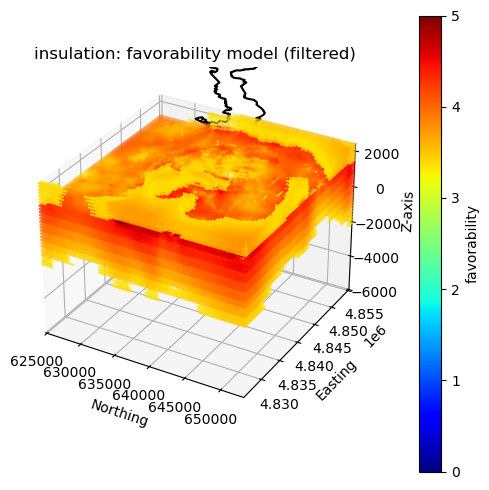

In [8]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model (filtered)"

        thresh = gdf[col].quantile(0.75)
        GeospatialDataPlotters.geo_plot_3d(
            gdf,
            col,
            units,
            title,
            area_outline=outline,
            extent=extent,
            figsize=(5, 5),
            markersize=0.5,
            filter_threshold=thresh,
        )

Example interpretation:
- "Heat favorability peaks at deeper portions of the domain."
- "Producibility favorability centers nearer the surface, aligning with high earthquake density."
- "Insulation favorability dominates near the top, where density, resitivity, and velocity are high."

### Component Favorability Models — Vertical Slices

Repeat the same component plots as vertical slices to visualize depth trends.

geologic
	heat


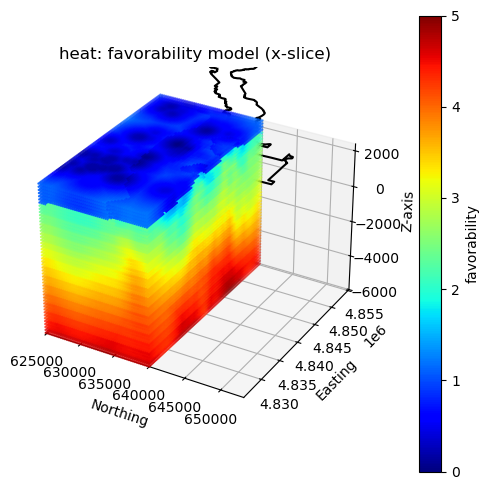

	producibility


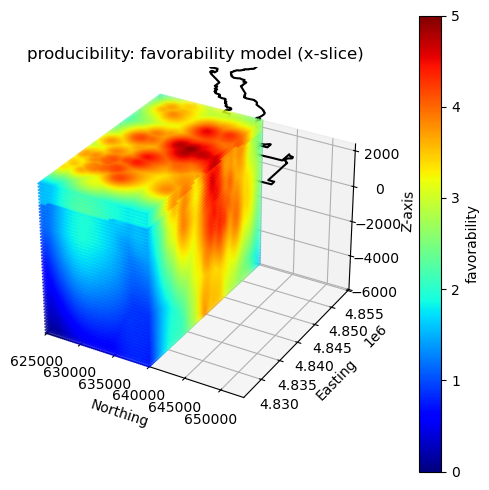

	insulation


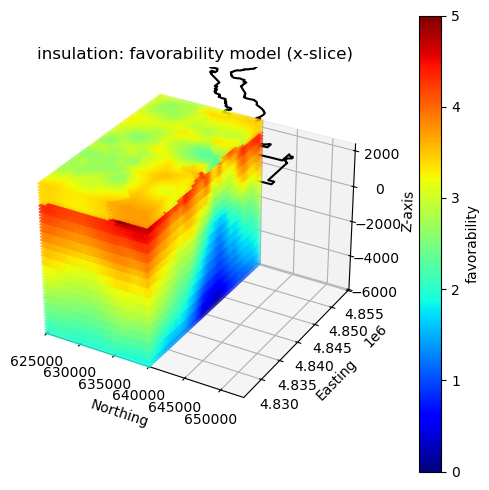

In [9]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model (x-slice)"

        GeospatialDataPlotters.geo_plot_3d(
            gdf,
            col,
            units,
            title,
            area_outline=outline,
            extent=extent,
            figsize=(5, 5),
            markersize=0.5,
            x_slice=640000,
        )

## 5. Exporting Favorability Models

The final step is to export the combined and component‐level favorability models as shapefiles.  
These outputs can be opened directly in **QGIS**, **ArcGIS**, or other geospatial tools for visualization and further analysis.

Each GeoDataFrame is written to a shapefile using `GeospatialDataWriters.write_shapefile()`,  
which preserves geometry, attributes, and the project CRS.


### Combined Favorability Model

In [10]:
output_dir = project_dir / "outputs"
output_dir.mkdir(exist_ok=True)

# Combined (overall) favorability
gdf = pfa["pr_norm"]
out_fp = output_dir / "combined_favorability_model_no_exclusions_highT.shp"

GeospatialDataWriters.write_shapefile(gdf, out_fp, target_crs)
print(f"✅ Combined favorability model written to: {out_fp}")

/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


✅ Combined favorability model written to: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/outputs/combined_favorability_model_no_exclusions_highT.shp


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


## Criteria- and Component-Level Models

Export each criteria model (e.g., geologic) and its components (heat, producibility, insulation).

In [11]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)

    # Criteria-level export
    crit_out_dir = output_dir / f"{criteria}_criteria_favorability_models"
    crit_out_dir.mkdir(exist_ok=True)

    gdf = crit_data["pr_norm"]
    crit_fp = crit_out_dir / f"{criteria}_criteria_favorability_model_highT.shp"
    GeospatialDataWriters.write_shapefile(gdf, crit_fp, target_crs)
    print(f"\t✅ Wrote {criteria} criteria model")

    # Component-level exports
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        comp_out_dir = output_dir / f"{component}_component_favorability_models"
        comp_out_dir.mkdir(exist_ok=True)

        gdf = comp_data["pr_norm"]
        comp_fp = comp_out_dir / f"{component}_component_favorability_model_highT.shp"
        GeospatialDataWriters.write_shapefile(gdf, comp_fp, target_crs)
        print(f"\t\t✅ Wrote {component} component model")

/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


geologic


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


	✅ Wrote geologic criteria model
	heat


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


		✅ Wrote heat component model
	producibility


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


		✅ Wrote producibility component model
	insulation
		✅ Wrote insulation component model


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


### Summary

You now have:
- A combined **geologic criteria favorability model**
  - **Note**: We do not recommend using this model for 3D interpretation due to a lack of visibility into components, given that each component exists in a distinct location in 3D space, stacked over one another. This means that the highest combined geologic favorability may indicate mild favorability for all components in an overlapping location, which is ultimately unfavorable for geothermal development.
- Individual **component favorability models**  

The resulting models can be exported as shapefiles or CSV files to be used for:
- Overlaying favorability with site infrastructure or exclusion zones  
- Cross-checking results against geologic models  
- Sharing results externally in standard GIS formats  

This concludes the example workflow for **import → data processing → layer combination → export**  
using `geoPFA` for the Newberry Volcano play fairway analysis.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import LineString, MultiLineString

def geo_plot_3d(
    gdf, col, units, title,
    area_outline=None, overlay=None, well_path=None, well_path_values=None,
    xlabel='default', ylabel='default', zlabel='Z-axis',
    cmap='jet', xlim=None, ylim=None, zlim=None, extent=None, markersize=15, figsize=(14, 5),
    vmin=None, vmax=None, filter_threshold=None, x_slice=None, y_slice=None, z_slice=None,
    # Well-path colorbar settings
    well_units='Temperature (°C)',
    well_cmap='magma',
    show_well_colorbar=True,
    # Main (favorability) colorbar settings
    show_main_colorbar=True,
    # Two-view controls
    view_main=(20, -60),     # (elev, azim)
    view_se=(20, 135),       # southeast view
    # Layout controls (fractions of figure width; thin bars so they don’t look chunky)
    cbar_width=0.035,
    panel_width_main=0.50,
    panel_width_se=0.415,
    suptitle_y=0.98
):
    """
    Plots 3D geospatial data with a main and a southeast view.
    Colorbars live in dedicated side columns, never overlapping content.
    """

    # ---------- helpers ----------
    def _coords3_from_point(pt):
        z = getattr(pt, "z", None)
        if z is None:
            c0 = pt.coords[0]
            z = c0[2] if len(c0) == 3 else 0.0
        return (pt.x, pt.y, z)

    def _build_well_pts(_well):
        if _well is None:
            return None
        if hasattr(_well, "geometry"):
            if all(g.geom_type == "Point" for g in _well.geometry):
                return np.array([_coords3_from_point(p) for p in _well.geometry], dtype=float)
            # fallback: lines in a GDF
            geoms = list(_well.geometry)
            merged = geoms[0]
            if len(geoms) > 1:
                try:
                    from shapely.ops import linemerge
                    merged = linemerge(geoms)
                except Exception:
                    pass
            if isinstance(merged, (LineString, MultiLineString)):
                parts = merged.geoms if isinstance(merged, MultiLineString) else [merged]
                arrs = []
                for ls in parts:
                    arr = np.asarray(ls.coords, dtype=float)
                    if arr.shape[1] == 2:
                        arr = np.c_[arr, np.zeros(len(arr))]
                    arrs.append(arr)
                return np.vstack(arrs) if arrs else None
            return None
        # plain shapely lines
        if isinstance(_well, (LineString, MultiLineString)):
            parts = _well.geoms if isinstance(_well, MultiLineString) else [_well]
            arrs = []
            for ls in parts:
                arr = np.asarray(ls.coords, dtype=float)
                if arr.shape[1] == 2:
                    arr = np.c_[arr, np.zeros(len(arr))]
                arrs.append(arr)
            return np.vstack(arrs) if arrs else None
        return None

    def _apply_slice_pts(arr):
        if arr is None:
            return None
        mask = np.ones(len(arr), dtype=bool)
        if x_slice is not None: mask &= arr[:, 0] <= x_slice
        if y_slice is not None: mask &= arr[:, 1] <= y_slice
        if z_slice is not None: mask &= arr[:, 2] <= z_slice
        return arr[mask]

    # ---------- prep main dataset ----------
    gdf_copy = gdf.copy()

    # main colormap/norm
    if col is not None and str(col).lower() != "none":
        vmin_main = gdf_copy[col].min() if vmin is None else vmin
        vmax_main = gdf_copy[col].max() if vmax is None else vmax
        norm_main = plt.Normalize(vmin=vmin_main, vmax=vmax_main)
        cmap_main_obj = plt.get_cmap(cmap)
    else:
        norm_main = None
        cmap_main_obj = None

    # slicing on first coordinate (matches your original semantics)
    if x_slice is not None:
        gdf_copy = gdf_copy[gdf_copy.geometry.apply(lambda geom: geom.coords[0][0] <= x_slice)]
    if y_slice is not None:
        gdf_copy = gdf_copy[gdf_copy.geometry.apply(lambda geom: geom.coords[0][1] <= y_slice)]
    if z_slice is not None:
        gdf_copy = gdf_copy[gdf_copy.geometry.apply(lambda geom: geom.coords[0][2] <= z_slice)]

    # threshold filter
    if filter_threshold is not None and col != "None":
        gdf_filtered = gdf_copy[gdf_copy[col] >= filter_threshold]
    else:
        gdf_filtered = gdf_copy

    if gdf_filtered.empty and well_path is None:
        print("No data to plot after filtering and slicing.")
        return

    # color array for points (only created if col provided)
    if (col is not None and str(col).lower() != "none") and not gdf_filtered.empty:
        filtered_colors = cmap_main_obj(norm_main(gdf_filtered[col]))
    else:
        filtered_colors = 'blue'

    # well points + values
    well_pts = _apply_slice_pts(_build_well_pts(well_path))
    well_vals = None if well_path_values is None else np.asarray(well_path_values)

    # ---------- figure layout: [well_cbar | main3D | se3D | main_cbar] ----------
    ratios = [cbar_width, panel_width_main, panel_width_se, cbar_width]
    total = sum(ratios)
    ratios = [r / total for r in ratios]  # normalize to 1.0 for GridSpec

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(1, 4, figure=fig, width_ratios=ratios)

    # axes
    ax_main = fig.add_subplot(gs[0, 1], projection='3d')
    ax_se   = fig.add_subplot(gs[0, 2], projection='3d')
    cax_left  = fig.add_subplot(gs[0, 0])  # 2D axes for well colorbar
    cax_right = fig.add_subplot(gs[0, 3])  # 2D axes for main colorbar

    # make cbar axes frameless but keep ticks/labels visible
    for cax in (cax_left, cax_right):
        for spine in cax.spines.values():
            spine.set_visible(False)

    # view angles
    ax_main.view_init(*view_main)
    ax_se.view_init(*view_se)

    # ---------- per-panel plotting ----------
    def _plot_on(ax, add_main_cbar=False, add_well_cbar=False):
        # main geometries
        if not gdf_filtered.empty:
            gtype0 = gdf_filtered.geometry.iloc[0].geom_type
            if gtype0 == 'Point':
                xs, ys, zs = zip(*[geom.coords[0] for geom in gdf_filtered.geometry])
                if isinstance(filtered_colors, str):
                    ax.scatter(xs, ys, zs, s=markersize, color=filtered_colors)
                else:
                    ax.scatter(xs, ys, zs, s=markersize, c=filtered_colors)
            elif gtype0 in ['Polygon', 'MultiPolygon']:
                for geom in gdf_filtered.geometry:
                    if geom.geom_type == 'Polygon':
                        rings = [geom.exterior] + list(geom.interiors)
                    elif geom.geom_type == 'MultiPolygon':
                        rings = [ring for polygon in geom.geoms
                                 for ring in [polygon.exterior] + list(polygon.interiors)]
                    else:
                        rings = []
                    for ring in rings:
                        verts = [(c[0], c[1], c[2] if len(c) == 3 else 0) for c in ring.coords]
                        ax.add_collection3d(
                            Poly3DCollection([verts], alpha=0.5, edgecolor='grey', facecolor='lightblue')
                        )

        # overlay
        if overlay is not None and hasattr(overlay, "empty") and not overlay.empty:
            ox, oy, oz = zip(*[geom.coords[0] for geom in overlay.geometry])
            ax.scatter(ox, oy, oz, color='gray', s=5, alpha=0.5)

        # well path scatter
        sc_well = None
        if well_pts is not None and len(well_pts):
            if well_vals is None:
                sc_well = ax.scatter(well_pts[:, 0], well_pts[:, 1], well_pts[:, 2],
                                     s=markersize * 1.6, color='k', alpha=0.9, zorder=5)
            else:
                vals = well_vals
                if len(vals) > len(well_pts):
                    vals = vals[:len(well_pts)]
                elif len(vals) < len(well_pts):
                    vals = np.concatenate([vals, np.full(len(well_pts) - len(vals), np.nan)])

                if np.isfinite(vals).any():
                    w_cmap = plt.get_cmap(well_cmap)
                    vmin_w = np.nanmin(vals) if vmin is None else vmin
                    vmax_w = np.nanmax(vals) if vmax is None else vmax
                    norm_w = plt.Normalize(vmin=vmin_w, vmax=vmax_w)
                    sc_well = ax.scatter(
                        well_pts[:, 0], well_pts[:, 1], well_pts[:, 2],
                        s=markersize * 1.6, c=vals, cmap=w_cmap, norm=norm_w, alpha=0.9, zorder=5
                    )
                else:
                    sc_well = ax.scatter(well_pts[:, 0], well_pts[:, 1], well_pts[:, 2],
                                         s=markersize * 1.6, color='k', alpha=0.9, zorder=5)

        # area outline
        if area_outline is not None and hasattr(area_outline, "empty") and not area_outline.empty:
            if not gdf_copy.empty and gdf_copy.geometry.iloc[0].geom_type == 'Point':
                zmax = max(geom.z for geom in gdf_copy.geometry)
            elif not gdf_copy.empty and gdf_copy.geometry.iloc[0].geom_type in ['Polygon', 'MultiPolygon']:
                zmax = max(
                    max(coord[2] for coord in ring.coords if len(coord) == 3)
                    for geom in gdf_copy.geometry
                    for ring in ([geom.exterior] + list(geom.interiors))
                )
            else:
                zmax = 0
            for poly in area_outline.geometry:
                xs, ys = zip(*[(c[0], c[1]) for c in poly.exterior.coords])
                zs = [zmax + 1] * len(xs)
                ax.plot(xs, ys, zs, color='black')

        # labels & limits
        _xlabel = xlabel if xlabel != 'default' else (gdf_copy.crs.axis_info[1].name if gdf_copy.crs else 'X-axis')
        _ylabel = ylabel if ylabel != 'default' else (gdf_copy.crs.axis_info[0].name if gdf_copy.crs else 'Y-axis')
        _zlabel = zlabel if zlabel else 'Z-axis'
        ax.set_xlabel(_xlabel); ax.set_ylabel(_ylabel); ax.set_zlabel(_zlabel)

        if extent is not None and zlim is None:
            ax.set_xlim(extent[0], extent[3]); ax.set_ylim(extent[1], extent[4]); ax.set_zlim(extent[2], extent[5])
        else:
            if xlim is not None: ax.set_xlim(xlim)
            if ylim is not None: ax.set_ylim(ylim)
            if zlim is not None: ax.set_zlim(zlim)

        ax.grid(True)

        # colorbars (draw into dedicated 2D axes; thin columns avoid chunky look)
        if add_main_cbar and (col is not None and str(col).lower() != "none") and not gdf_filtered.empty:
            sm = plt.cm.ScalarMappable(cmap=cmap_main_obj, norm=norm_main)
            cax_right.cla()
            cb = plt.colorbar(sm, cax=cax_right)
            cb.set_label(units)
            cb.locator = MaxNLocator(nbins=6); cb.update_ticks()
            cb.ax.tick_params(labelsize=9)

        if add_well_cbar and sc_well is not None and show_well_colorbar and well_vals is not None:
            cax_left.cla()
            cbw = plt.colorbar(sc_well, cax=cax_left)
            cbw.set_label(well_units)
            cbw.locator = MaxNLocator(nbins=6); cbw.update_ticks()
            cbw.ax.tick_params(labelsize=9)
            # If you want ticks on the left edge:
            cbw.ax.yaxis.set_ticks_position('left')
            cbw.ax.yaxis.set_label_position('left')

    # plot both panels; add colorbars only once (main panel)
    _plot_on(ax_main, add_main_cbar=show_main_colorbar, add_well_cbar=show_well_colorbar)
    _plot_on(ax_se,   add_main_cbar=False,            add_well_cbar=False)

    # titles
    ax_main.set_title(f"{title} — NW view")
    ax_se.set_title(f"{title} — SE view")

    plt.show()


In [110]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

class DataReaders:

    @staticmethod
    def read_well_path_csv(
        csv_path,
        x_col,
        y_col,
        z_col=None,
        *,
        well_name_col=None,      # optional
        value_col=None,          # optional per-vertex values (temp/GR/etc.)
        source_crs=None,
        to_crs=None,
        sort_by=None,
        md_col=None,
        dropna_any=True,
        deduplicate_consecutive=True,
        z_meas=None,
        target_z_meas=None,
        convert_z_after=True
    ):
        """Reads a well-path CSV and returns a point GeoDataFrame (ordered vertices) and optional values.

        Parameters
        ----------
        csv_path : 'str'
            Path to the CSV file containing well path vertices.
        x_col : 'str'
            Column name for X (or longitude).
        y_col : 'str'
            Column name for Y (or latitude).
        z_col : 'str', optional
            Column name for Z (depth or elevation). If omitted, Z=0.
        well_name_col : 'str', optional
            Column name for well name; stored in output.
        value_col : 'str', optional
            Column name for per-vertex values (e.g., Temperature, GR).
        source_crs : 'int or str', optional
            Input CRS for X/Y. Example: 32613 or 4326.
        to_crs : 'int or str', optional
            Output CRS for reprojection.
        sort_by : 'str', optional
            Column to sort by before building points (e.g., 'MD_m').
        md_col : 'str', optional
            If provided and sort_by is None, rows are sorted by this column.
        dropna_any : 'bool'
            If True, drop rows with any NaN in X/Y/Z; else only drop rows with all NaNs.
        deduplicate_consecutive : 'bool'
            If True, drop consecutive duplicate XY Z vertices.
        z_meas : 'str', optional
            Vertical reference of Z in the CSV (e.g., 'depth', 'm-msl', 'epsg:5703').
        target_z_meas : 'str', optional
            Desired vertical reference (e.g., 'm-msl', 'ft-msl', 'epsg:6360').
        convert_z_after : 'bool'
            If True and z_meas/target_z_meas provided, converts Z via convert_z_measurements().

        Returns
        -------
        well_gdf : GeoDataFrame
            Ordered vertices as 3D Point geometries (one row per vertex).
        values : np.ndarray or None
            Per-vertex values aligned with rows (or None if value_col not provided).
        """
        df = pd.read_csv(csv_path)

        # Pull coordinates
        x = df[x_col].astype(float).to_numpy()
        y = df[y_col].astype(float).to_numpy()
        if z_col is not None:
            z = df[z_col].astype(float).to_numpy()
        else:
            z = np.zeros_like(x, dtype=float)

        coords = np.column_stack([x, y, z])

        # Drop NaNs
        if dropna_any:
            mask = ~np.isnan(coords).any(axis=1)
        else:
            mask = ~(np.isnan(coords).all(axis=1))
        df = df.loc[mask].reset_index(drop=True)
        coords = coords[mask]

        if coords.shape[0] < 2:
            raise ValueError("Not enough valid vertices to define a well path.")

        # Sorting
        if sort_by is None and md_col is not None and md_col in df.columns:
            sort_by = md_col
        if sort_by is not None and sort_by in df.columns:
            order = np.argsort(df[sort_by].to_numpy())
            df = df.iloc[order].reset_index(drop=True)
            coords = coords[order]

        # De-duplicate consecutive vertices
        if deduplicate_consecutive and len(coords) > 1:
            keep = np.ones(len(coords), dtype=bool)
            keep[1:] = (np.abs(np.diff(coords, axis=0)) > 0).any(axis=1)
            df = df.loc[keep].reset_index(drop=True)
            coords = coords[keep]
            if len(coords) < 2:
                raise ValueError("Well path collapsed to one vertex after de-duplication.")

        # Build point GeoDataFrame
        geometries = [Point(float(X), float(Y), float(Z)) for X, Y, Z in coords]
        well_name = df[well_name_col].iloc[0] if (well_name_col and well_name_col in df.columns) else None
        well_gdf = gpd.GeoDataFrame(
            {'name': [well_name] * len(geometries)},
            geometry=geometries,
            crs=source_crs
        )

        # Reproject horizontal CRS if requested
        if to_crs is not None:
            well_gdf = well_gdf.to_crs(to_crs)

        # Optional per-vertex values
        values = None
        if value_col is not None:
            if value_col not in df.columns:
                raise ValueError(f"Column '{value_col}' not found for values.")
            values = df[value_col].to_numpy()
            # Align to vertex count
            if len(values) > len(well_gdf):
                values = values[:len(well_gdf)]
            elif len(values) < len(well_gdf):
                pad = np.full(len(well_gdf) - len(values), np.nan)
                values = np.concatenate([values, pad])

        # Optional vertical conversion (expects point Zs in geometry)
        if convert_z_after and z_meas is not None and target_z_meas is not None:
            from geopfa.processing.Processing import convert_z_measurements
            well_gdf = convert_z_measurements(well_gdf, z_meas, target_z_meas)

        return well_gdf, values


In [111]:
well_path_file_path = data_dir / "supporting_data" / "Well Data" / "NWG55-29_TEMP.csv"

well_gdf, well_values = DataReaders.read_well_path_csv(
    csv_path=well_path_file_path,
    x_col="X_val",
    y_col="Y_val",
    z_col="Z_val",
    well_name_col="WellID",
    value_col="TEMP_corr",     # now clean + aligned with well_path_values
    source_crs=target_crs,
    to_crs=target_crs,
    z_meas="m-msl",
    target_z_meas="m-msl",
    convert_z_after=False
)

stride = 100
well_gdf_thinned = well_gdf.iloc[::stride].copy()
if well_values is not None:
    well_values_thinned = well_values[::stride]
else:
    well_values_thinned = None



geologic
	heat


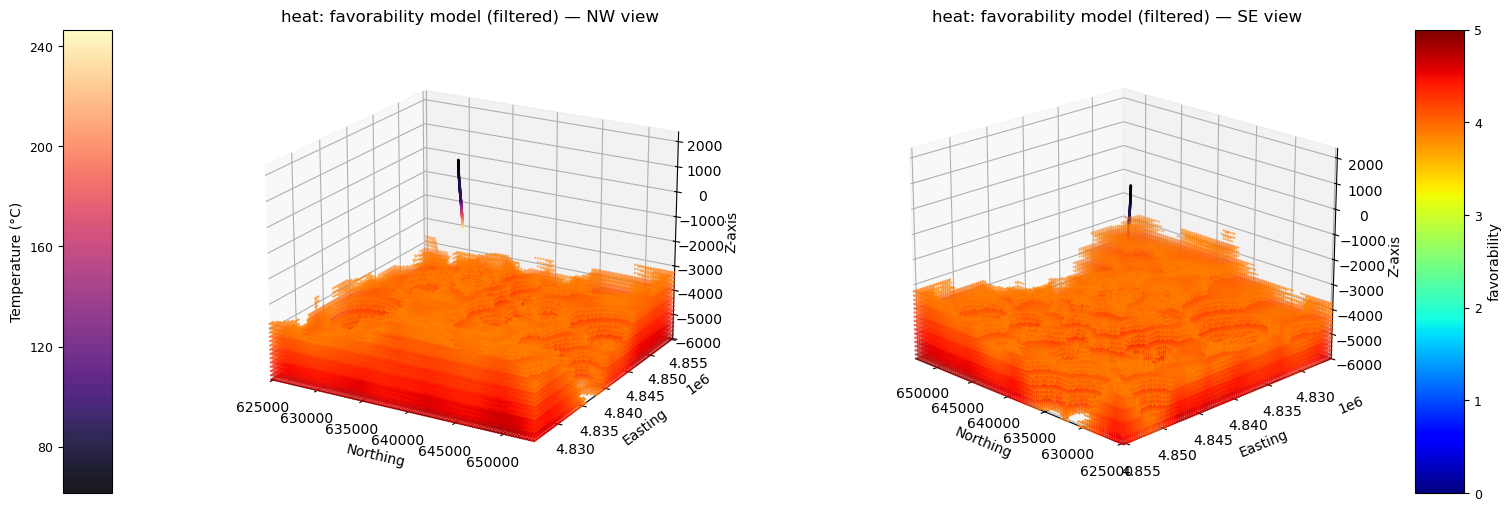

	producibility


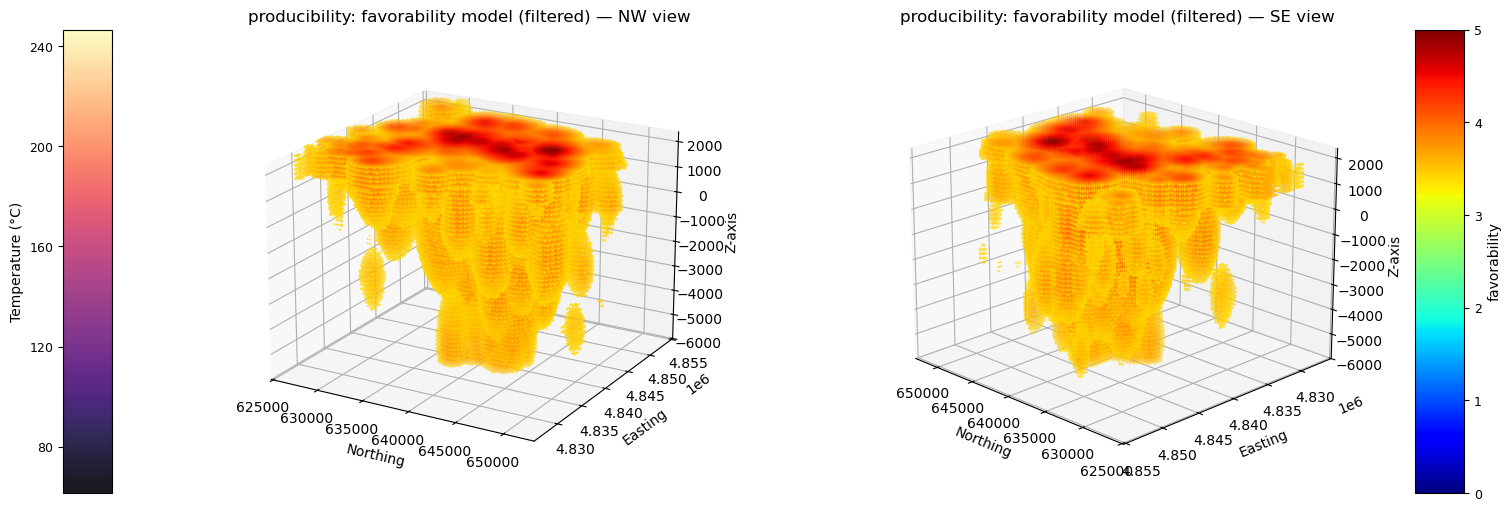

	insulation


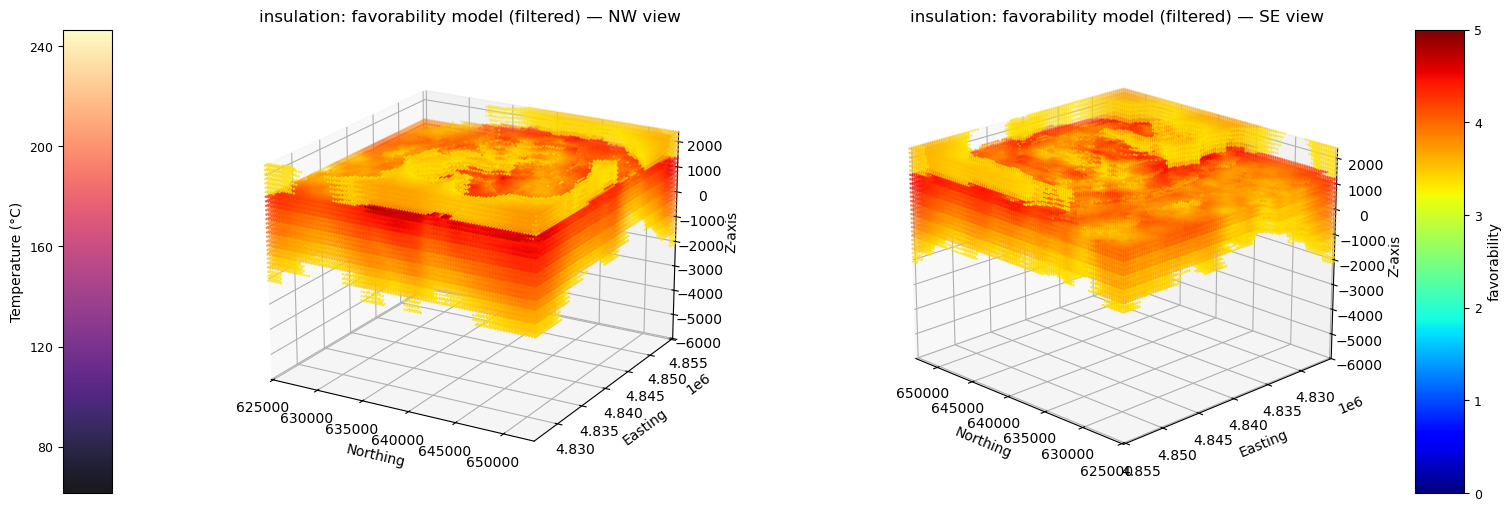

In [112]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model (filtered)"

        thresh = gdf[col].quantile(0.75)
        geo_plot_3d(
            gdf,
            col,
            units,
            title,
            well_path=well_gdf_thinned,
            well_path_values=well_values_thinned,
            extent=extent,
            figsize=(15, 5),
            markersize=0.5,
            filter_threshold=thresh,
        )